# Datamining Techniques Project 1 Advanced

Changxin Miao 11853018 cmo440

Michael Mo 10770518 mmo740

Féliciën Veldema 10739335 Fva350

In [29]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import warnings
import datetime

from pandas import tseries
from pathlib import Path
from scipy import stats
from scipy.stats import pearsonr
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX



### Data processing


In [3]:
#LOAD The data
path = 'dataset_mood_smartphone.csv'
df = pd.read_csv(path, header=0, sep=',', index_col=0)

#Split time column into time and date
date, time = df['time'].str.split(' ', 1).str
df.drop(labels=['time'], axis=1,inplace = True)
df.insert(1, 'date', date)
df.insert(2, 'time', time)

#sort on id and date
df = df.sort_values(by=['id', 'date'])

#Get the unique id's and data variables
ids = df.id.unique()
inputs = df.variable.unique()
uniquedays = df.date.unique()


In [4]:
#function to merge the days of the variables per patient  ##Note takes a while to complete
def mergedays(df):
    table = pd.DataFrame(columns=['id','date', 'variable', 'value'])
    ids = df.id.unique()
    #Rebuild the dataframe for every patient, day , variable
    i = 0
    for patientid in ids:
        patientdata = df.loc[df['id'] == patientid]
        days = patientdata.date.unique()
        for day in days:
            daydata = patientdata.loc[patientdata['date'] == day]
            variables = daydata.variable.unique()
            for var in variables:
                if var == 'mood' or var == 'circumplex.arousal' or var == 'circumplex.valence':
                    value = daydata.loc[daydata['variable'] == var].mean()[0]
                elif var == 'activity':
                    value = daydata.loc[daydata['variable'] == var].max()[4]
                else:
                    #note due to sum suming over all indexing is needed
                    value = daydata.loc[daydata['variable'] == var].sum()[4]

                #print([patientid,day,var,value])
                table.loc[i] = [patientid,day,var,value]
                i+=1
    return table

In [5]:
#STATUS PRINTS      #NOTE before cleaning
print("STATISTICS")
print("The amount of unique ids are: ", len(ids), "\n", ids)
print("Amount of unique days are: ", len(uniquedays), "\n", uniquedays)
print("\nThe variables used are:\n", inputs)

print("\nErrors are within:  circumplex.valence 156 NA & circumplex.arousal 46 NA")
print("The count and amount of data inputs do not match")

print("\nHow many data points per id:")
datalist = []
for i in ids:
    datalist.append(len(df.loc[df['id'] == i]))
    print(i, " amount of data inputs: ", len(df.loc[df['id'] == i]))

vardatalist = []
print("\nHow often are the variables used:")
for j in inputs:
    vardatalist.append(len(df.loc[df['variable'] == j]))
    print(j, "\nAmount of data inputs: ", len(df.loc[df['variable'] == j]))
    print(df.loc[df['variable'] == j].describe(),"\n")
    
    



STATISTICS
The amount of unique ids are:  27 
 ['AS14.01' 'AS14.02' 'AS14.03' 'AS14.05' 'AS14.06' 'AS14.07' 'AS14.08'
 'AS14.09' 'AS14.12' 'AS14.13' 'AS14.14' 'AS14.15' 'AS14.16' 'AS14.17'
 'AS14.19' 'AS14.20' 'AS14.23' 'AS14.24' 'AS14.25' 'AS14.26' 'AS14.27'
 'AS14.28' 'AS14.29' 'AS14.30' 'AS14.31' 'AS14.32' 'AS14.33']
Amount of unique days are:  113 
 ['2014-02-17' '2014-02-18' '2014-02-19' '2014-02-20' '2014-02-21'
 '2014-02-22' '2014-02-25' '2014-02-26' '2014-02-27' '2014-02-28'
 '2014-03-01' '2014-03-03' '2014-03-05' '2014-03-06' '2014-03-07'
 '2014-03-10' '2014-03-11' '2014-03-12' '2014-03-13' '2014-03-14'
 '2014-03-15' '2014-03-16' '2014-03-17' '2014-03-18' '2014-03-19'
 '2014-03-20' '2014-03-21' '2014-03-22' '2014-03-23' '2014-03-24'
 '2014-03-25' '2014-03-26' '2014-03-27' '2014-03-28' '2014-03-29'
 '2014-03-30' '2014-03-31' '2014-04-01' '2014-04-02' '2014-04-03'
 '2014-04-04' '2014-04-05' '2014-04-06' '2014-04-07' '2014-04-08'
 '2014-04-09' '2014-04-10' '2014-04-11' '2014-04-1

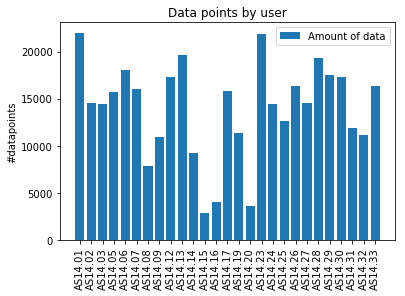

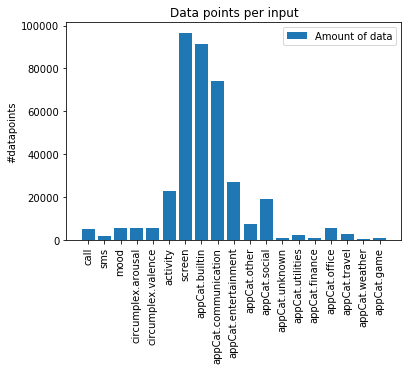

In [6]:
#plot the data points per id
fig, ax = plt.subplots()
ax.bar(np.arange(len(ids)),datalist,0.8,label='Amount of data')
ax.set_ylabel('#datapoints')
ax.set_title('Data points by user')
ax.set_xticks(np.arange(len(ids)))
ax.set_xticklabels(('AS14.01','AS14.02','AS14.03','AS14.05','AS14.06','AS14.07','AS14.08'
 ,'AS14.09', 'AS14.12', 'AS14.13','AS14.14','AS14.15','AS14.16','AS14.17',
 'AS14.19', 'AS14.20', 'AS14.23', 'AS14.24', 'AS14.25', 'AS14.26','AS14.27',
 'AS14.28', 'AS14.29', 'AS14.30','AS14.31','AS14.32','AS14.33'),rotation='vertical')
ax.legend()
plt.show()


#plot data points per variable
fig, bx = plt.subplots()
bx.bar(np.arange(len(inputs)),vardatalist,0.8,label='Amount of data')
bx.set_ylabel('#datapoints')
bx.set_title('Data points per input')
bx.set_xticks(np.arange(len(inputs)))
bx.set_xticklabels(('call','sms','mood','circumplex.arousal','circumplex.valence','activity'
 ,'screen','appCat.builtin','appCat.communication','appCat.entertainment'
 ,'appCat.other','appCat.social','appCat.unknown','appCat.utilities'
 ,'appCat.finance','appCat.office','appCat.travel','appCat.weather'
 ,'appCat.game'),rotation='vertical')
bx.legend()
plt.show()

In [7]:
# Clean data from NA
df = df.dropna(axis=0, how='any')

###Check to see the cleaning result
# print("\nHow often are the variables used:")
# for j in inputs:
#     print(j, "\nAmount of data inputs: ", len(df.loc[df['variable'] == j]))
#     print(df.loc[df['variable'] == j].describe(),"\n")
###
# print(df)

In [8]:
#Write / load the data

fname = "adjusted_data_activ.csv"
my_file = Path(fname)
if my_file.exists():
    print("file found, loading in now")
    df = pd.read_csv(fname, header=0, sep=',', index_col=0)
else:
    print("file not found")
    df = mergedays(df)
    df.to_csv(fname, sep=',')
    print("writing completed")

print(df)

file found, loading in now
            id        date              variable        value
0      AS14.01  2014-02-17                  call     2.000000
1      AS14.01  2014-02-18                  call     1.000000
2      AS14.01  2014-02-19                  call     7.000000
3      AS14.01  2014-02-19                   sms     2.000000
4      AS14.01  2014-02-20                  call     2.000000
5      AS14.01  2014-02-20                   sms     3.000000
6      AS14.01  2014-02-21                   sms     1.000000
7      AS14.01  2014-02-22                  call     2.000000
8      AS14.01  2014-02-22                   sms     1.000000
9      AS14.01  2014-02-25                  call     3.000000
10     AS14.01  2014-02-26                  mood     6.250000
11     AS14.01  2014-02-26    circumplex.arousal    -0.250000
12     AS14.01  2014-02-26    circumplex.valence     0.750000
13     AS14.01  2014-02-26                  call     1.000000
14     AS14.01  2014-02-26                 

In [9]:
#Correlations
#NOTE assumes the cleaned data  FROM 2 cells below. TODO SWITCH ORDER. not done due to git
def addpval(variablelist):
    newlist = ['id']
    for i in variablelist:
        newlist.append(i)
        newlist.append(i + ' p-val')
    return newlist

def correlations(df):
    patients = df.id.unique().tolist()
    variables = df.variable.unique().tolist()
    variables.remove('mood')
    columnlist = addpval(variables)
    data = []
    
    for patientid in patients:
        datarow = [patientid]
        for var in variables:
            cor = corrperpatient(patientid, var)
            datarow.append(cor[0])
            datarow.append(cor[1])
        data.append(datarow)
    correlations = pd.DataFrame(data,columns=columnlist)
    return correlations
        
        
def checkio(data):
    for index in range(len(data) - 1, -1, -1):
        if data.count(data[index]) == 1:
            del data[index]
    return np.unique(data)

def corrperpatient(patientid, var):
    test = df.loc[df['id'] == patientid]
    moodcol = test.loc[(test['variable'] == 'mood')]
    mooddays = moodcol.date.unique()
    varcol = test.loc[(test['variable'] == var )]
    vardays = varcol.date.unique()
    
    validdates = checkio(list(np.append(mooddays,vardays)))
    moodlist = []
    varlist = []
    for day in validdates:
        moodlist.append(moodcol.loc[(moodcol['date'] == day)]['value'].item())
        varlist.append(varcol.loc[(varcol['date'] == day)]['value'].item())
    d = {'mood': moodlist, var: varlist}
    cordata = pd.DataFrame(data=d).dropna() 
    return pearsonr(cordata['mood'], cordata[var])

warnings.filterwarnings('ignore')
corrdata = correlations(df)
warnings.filterwarnings('always')

##
# print("Writing correlations file")
# fname = "mood_correlated_data.csv"
# correlations.to_csv(fname, sep=',')

print(corrdata[['id','call p-val',"activity p-val", 'circumplex.valence p-val']])

         id  call p-val  activity p-val  circumplex.valence p-val
0   AS14.01    0.346188        0.061622              1.274928e-11
1   AS14.02    0.574067        0.114649              2.143439e-08
2   AS14.03    0.759739        0.989526              2.328591e-05
3   AS14.05    0.210856        0.136632              1.875132e-19
4   AS14.06    0.712663        0.932283              9.594017e-08
5   AS14.07    0.917852        0.035707              3.483144e-16
6   AS14.08    0.308922        0.265304              1.143010e-16
7   AS14.09    0.415889        0.000029              1.600325e-13
8   AS14.12    0.214285        0.681544              1.635620e-10
9   AS14.13    0.929014        0.077460              3.114415e-14
10  AS14.14    0.518193        0.902835              7.950326e-09
11  AS14.15    0.378788        0.062350              2.052685e-15
12  AS14.16    0.282240        0.111147              4.985749e-10
13  AS14.17    0.141560        0.702319              1.279075e-02
14  AS14.1

# Non temporal model

In [10]:
# creates table, row: timesteps 0,..,T, columns variables
def create_table_for_patient(df, patient_id):
    # Only get rows for patient_id
    df_pat = df.loc[df['id'] == patient_id ]
    
    # Calculate num_days all measurements come from
    date_format = "%Y-%m-%d"
    pat_start_date = datetime.datetime.strptime(df_pat.loc[ df_pat.head(1).index[0], 'date'], date_format)
    pat_end_date = datetime.datetime.strptime(df_pat.loc[ df_pat.tail(1).index[0], 'date'], date_format)
    num_days = (pat_end_date - pat_start_date).days + 1

    # all except mood
    q = ['circumplex.arousal', 'circumplex.valence',
         'activity', 'screen', 'call', 'sms',
         'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance',
         'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
         'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']

    # Create df_pat_table for num_days containing all measurements
    # missing values for mood are set to -1
    df_pat_table = pd.DataFrame(-1, index=range(0,num_days), columns=['mood'])

    # not mentioned values are assumed to be 0
    for var in q:
        df_pat_table[var] = 0.0

    # fill in the table
    for index,rows in df_pat.iterrows():
        cur_date = rows['date']
        t = (datetime.datetime.strptime(cur_date, date_format) - pat_start_date).days
    
        cur_row_var = rows['variable']
        cur_row_val = rows['value']
    
        if cur_row_var in (q+['mood']):
            df_pat_table.loc[t, cur_row_var] = cur_row_val

    return df_pat_table

# example: df_q = create_table_for_patient(df, 'AS14.13')


In [11]:
# Returns features for a given slice of timestep table (of size window)
def feature_creation(df_time_history):
    # uses window of size 3
    window = df_time_history.shape[0]
    
    # df_time_history is df of indices t-window,...,t-1,
    # df_time_history.iloc[-k] gives you exactly row corresponding to row t-k of df df_time_history
    
    # mood at previous day, estimates for diff/change of diff of mood in window based finite difference method,
    # and avg mood during window
    prev_mood = df_time_history.iloc[-1]['mood']
    mood_diff = df_time_history.iloc[-1]['mood'] - df_time_history.iloc[-2]['mood']
    mood_change = df_time_history.iloc[-1]['mood'] - 2*df_time_history.iloc[-2]['mood'] + df_time_history.iloc[-3]['mood']
    avg_mood = sum(np.array(df_time_history.loc[:,'mood'])) / window
    
    # circumplex arousal and valence of previous day
    prev_circ_arousal = df_time_history.iloc[-1]['circumplex.arousal']
    prev_circ_valence = df_time_history.iloc[-1]['circumplex.valence']
    
    # total number of sms and calls during window
    sms_list = np.array(df_time_history.loc[:,'sms'])
    call_list = np.array(df_time_history.loc[:,'call'])
    tot_sms = sum(sms_list)
    tot_call = sum(call_list)
    
    # max time spent on a day on app X, during past window
    max_app_travel = max(np.array(df_time_history.loc[:,'appCat.travel']))
    max_app_finance = max(np.array(df_time_history.loc[:,'appCat.finance']))
    max_app_weather = max(np.array(df_time_history.loc[:,'appCat.weather']))
    max_app_office = max(np.array(df_time_history.loc[:,'appCat.office']))
    
    # max activity for a day, and avg screen time during past window
    avg_max_activity = max(np.array(df_time_history.loc[:,'activity'])) / window
    avg_screen = sum(np.array(df_time_history.loc[:,'screen'])) / window
    
    features = [ prev_mood, mood_diff, mood_change, avg_mood,
                 prev_circ_arousal, prev_circ_valence,
                 tot_sms,tot_call,
                 max_app_travel,max_app_finance,max_app_weather,max_app_office,
                 avg_screen,avg_max_activity]
                
    return features

In [12]:
# create dataset of instances for given table of a patient
# N = num datapoints
# data = [features, targets, timesteps]   features = N x K array, target = N-dim array, timesteps = N-dim array 
def extract_data(df_pat_table):

    target_list = []
    features_list = []
    time_list = []
    
    num_days = df_pat_table.shape[0]
    mood_list = np.array(df_pat_table['mood'])
    sms_list = np.array(df_pat_table['sms'])
    call_list = np.array(df_pat_table['call'])
    
    window = 3 # >=1
    for t in range(window,num_days):
        if (-1 in mood_list[t-window:t+1]) == False:
            # Example: t = 6, df_pat_table.loc[6-3:6-1]=df_pat_table.loc[3:5] = rows of df_pat with index 3,4,5
            features = feature_creation(df_pat_table.loc[t-window:t-1])

            target = mood_list[t]
    
            features_list.append(features)
            target_list.append(target)
            time_list.append(t)
    
    data = [features_list, target_list, time_list]
    return data

#example:
#df_q = create_table_for_patient(df, 'AS14.13')
#f_list, t_list, temp = extract_data(df_q)

In [13]:
patient_ids = ['AS14.01','AS14.02','AS14.03','AS14.05','AS14.06','AS14.07','AS14.08','AS14.09','AS14.12',
               'AS14.13','AS14.14','AS14.15','AS14.16','AS14.17','AS14.19','AS14.20','AS14.23','AS14.24',
               'AS14.25','AS14.26','AS14.27','AS14.28','AS14.29','AS14.30','AS14.31','AS14.32','AS14.33']
# Datasets:
#  test set consists of patients  : 1 9 23 29 32
#  val set consists of patients   : 2 8 14 17 30
#  train seet consists of patients: 3 5 6 7 12 13 15 16 19 20 24 25 26 27 28 31 33
test_patient_ids = ['AS14.01','AS14.09','AS14.23','AS14.29','AS14.32']
val_patient_ids = ['AS14.02','AS14.08','AS14.14','AS14.17','AS14.30']
train_patient_ids = ['AS14.03','AS14.05','AS14.06','AS14.07','AS14.12',
                     'AS14.13','AS14.15','AS14.16','AS14.19','AS14.20',
                     'AS14.24','AS14.25','AS14.26','AS14.27','AS14.28',
                     'AS14.31','AS14.33']

# Create test, validation and training sets
test_X = []; test_y = []; test_times = []
val_X = []; val_y = []; val_times = []
train_X =[]; train_y = []; train_times = []

for i in range(0,len(patient_ids)):
    df_pat_table = create_table_for_patient(df, patient_ids[i])
    f_list,t_list,times_list = extract_data(df_pat_table)

    if patient_ids[i] in test_patient_ids:
        test_X = test_X + f_list
        test_y = test_y + t_list
        test_times = test_times + times_list
    elif patient_ids[i] in val_patient_ids:
        val_X = val_X + f_list
        val_y = val_y + t_list
        val_times = val_times + times_list
    elif patient_ids[i] in train_patient_ids:
        train_X = train_X + f_list
        train_y = train_y + t_list
        train_times = train_times + times_list
    else:
        print("unknown patient")
    
num_data_points = len(test_X)+len(val_X)+len(train_X)
print("total number of data instances created: "+ str(num_data_points))
print("number of data instances in test set: " + str(len(test_X)))
print("number of data instances in val set: " + str(len(val_X)))
print("number of data instances in train set: "  +str(len(train_X)))


total number of data instances created: 1127
number of data instances in test set: 175
number of data instances in val set: 225
number of data instances in train set: 727


In [14]:
# Optimize DT for hyperparameters: min_samples_leaf
# using training and validation set

#hyper parameters:
min_samp_leaf = [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

val_errors = np.zeros(len(min_samp_leaf))

for k in range(0,len(min_samp_leaf)):
    # Create DT regressor
    DT_regressor_k = DecisionTreeRegressor(min_samples_leaf=min_samp_leaf[k])

    # Train DT on the training data
    DT_regressor_k.fit(train_X,train_y)

    # Check how good prediction is
    preds_k = DT_regressor_k.predict(val_X)

    # Remember MSE
    val_errors[k] = mean_squared_error(preds_k, val_y)

print("validation errors:")
print(val_errors)

k = np.argmin(val_errors)
print("Best performance on validation set, is using min samples leaf node = " + str(min_samp_leaf[k]))


validation errors:
[ 0.73155062  0.50222856  0.47862798  0.44223102  0.44126969  0.40971994
  0.40541585  0.40014483  0.40211944  0.41835097  0.3587311   0.33804789
  0.33877318  0.3290075   0.32497329  0.33411326  0.33161908  0.36956497
  0.37416785  0.33870736  0.36802117]
Best performance on validation set, is using min samples leaf node = 70


In [15]:
# Create the found optimalized DT regressor
DT_regressor = DecisionTreeRegressor(min_samples_leaf=70)

# Train DT on the training data
DT_regressor.fit(train_X,train_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=70,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [16]:
# Display the decision tree regressor as flowchart
f_names = ['prev_mood', 'mood_diff', 'mood_change', 'avg_mood',
           'prev_circ_arousal', 'prev_circ_valence',
           'tot_sms','tot_call',
           'max_app_travel','max_app_finance','max_app_weather','max_app_office',
           'avg_screen','avg_max_activity']
dot_data = tree.export_graphviz(DT_regressor, feature_names=f_names, out_file=None)
#dot_data = tree.export_graphviz(DT_regressor, out_file=None)
graph = graphviz.Source(dot_data)
graph

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

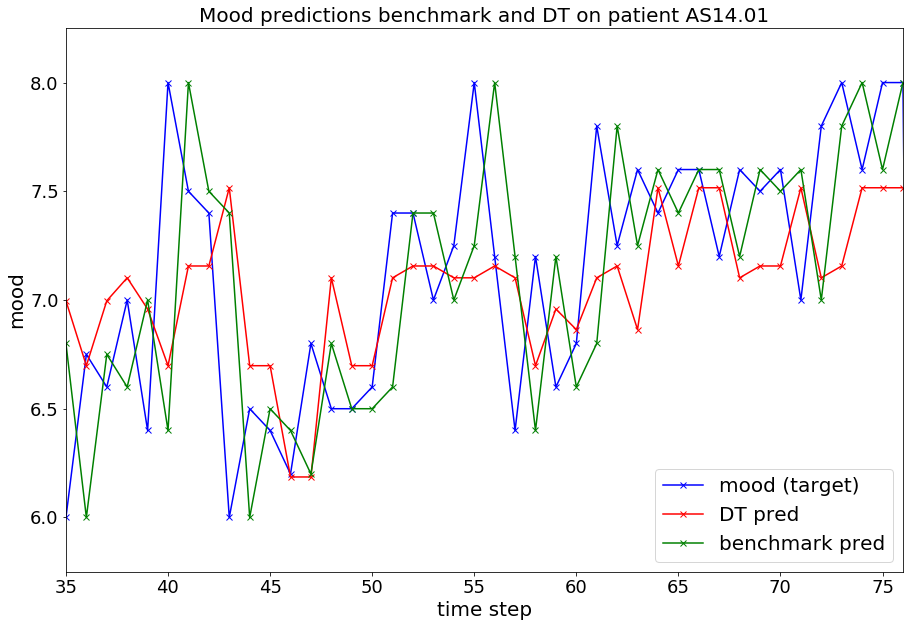

In [17]:
# check for all patients in test set the predictions over time (compared with benchmark)
for test_patient in ['AS14.01']: #'AS14.01' is in the test set "test_patient_ids"
    df_pat_q = create_table_for_patient(df, test_patient)
    f_list_q,t_list_q,time_q = extract_data(df_pat_q)
    q_pred = DT_regressor.predict(f_list_q)

    num_days = df_pat_q.shape[0]
    mood_list_q = np.array(df_pat_q['mood'])
    x = np.arange(0,num_days)
    plt.figure(figsize=(15,10))
    plt.plot(x,mood_list_q,'b',marker='x',label='mood (target)')
    plt.plot(time_q,q_pred,'r',marker='x',label='DT pred')
    z = mood_list_q[0:-1]
    z_x = x[1:]
    plt.plot(z_x,z,'g',marker='x',label='benchmark pred')
    plt.xlim(35,76)
    plt.ylim(5.75,8.25)
    plt.xlabel('time step',size=20)
    plt.ylabel('mood',size=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.title("Mood predictions benchmark and DT on patient AS14.01",size=20)
    plt.legend(loc='lower right', fontsize=20)
    plt.show()

MSE on test set benchmark: 0.469574603175
MSE on test set DT: 0.403900565495
Ttest_indResult(statistic=0.9833883374222846, pvalue=0.32611820007281134)


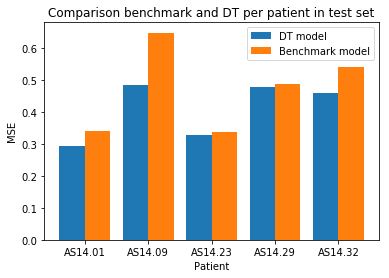

In [18]:
# t-test over 1 patient to see if really difference

all_avg_err_benchmark= []
all_avg_err_DT = []
all_err_benchmark = []
all_err_DT = []

# repeat for eacht patient int test set
for test_patient in test_patient_ids:

    # compare whether DT is better then benchmark (over 1 patient):
    # (where DT can predict, benchmark can definityle predict)
    errors_benchmark = []
    errors_DT = []

    df_pat_q = create_table_for_patient(df, test_patient)
    f_list_q,t_list_q,time_q = extract_data(df_pat_q)
    q_pred = DT_regressor.predict(f_list_q)
    mood_list_q = np.array(df_pat_q['mood'])
    
    # only check for times t, in time_q
    for k in range(0,len(time_q)):
        t = time_q[k]
        errors_benchmark.append( (mood_list_q[t] - mood_list_q[t-1])**2 )
        errors_DT.append( (mood_list_q[t] - q_pred[k])**2 )

    avg_err_benchmark = sum(errors_benchmark)/len(errors_benchmark)
    avg_err_DT = sum(errors_DT)/len(errors_DT)
#    print("For patient: " + test_patient)
#    print("avg err benchmark: " + str(avg_err_benchmark))
#    print("avg err DT: " + str(avg_err_DT))

    # t test
#    result = stats.ttest_ind(errors_benchmark, errors_DT,equal_var = False)
#    print(result)
#    print("\n")
    
    all_avg_err_benchmark.append(avg_err_benchmark)
    all_avg_err_DT.append(avg_err_DT)
    all_err_benchmark = all_err_benchmark + errors_benchmark
    all_err_DT = all_err_DT + errors_DT

print("MSE on test set benchmark: " + str(sum(all_err_benchmark)/len(all_err_benchmark)))
print("MSE on test set DT: " + str(sum(all_err_DT)/len(all_err_DT)))
result = stats.ttest_ind(all_err_benchmark, all_err_DT,equal_var = False)
print(result)

# plot of avg errors benchmark vs DT for the test patients
x = np.arange(0,len(all_avg_err_benchmark))
#plt.plot(x,all_avg_err_DT,'r',marker='x', linestyle='None', label='DT model')
#plt.plot(x,all_avg_err_benchmark,'g',marker='x', linestyle='None', label='Benchmark model')
plt.bar(x-0.2,all_avg_err_DT,width=0.4, label='DT model')
plt.bar(x+0.2,all_avg_err_benchmark,width=0.4, label='Benchmark model')
plt.xticks(x,test_patient_ids)
plt.xlabel('Patient')
plt.ylabel('MSE')
plt.title("Comparison benchmark and DT per patient in test set")
plt.legend(loc='upper right')
plt.show()



In [19]:
# Function to check mood over time for each patient

patient_ids = ['AS14.01','AS14.02','AS14.03','AS14.05','AS14.06','AS14.07','AS14.08','AS14.09','AS14.12',
               'AS14.13','AS14.14','AS14.15','AS14.16','AS14.17','AS14.19','AS14.20','AS14.23','AS14.24',
               'AS14.25','AS14.26','AS14.27','AS14.28','AS14.29','AS14.30','AS14.31','AS14.32','AS14.33']
def plot_moods_patients():

    #plt.figure(figsize=(20,10))
    for i in range(0,len(patient_ids)):
        df_table = create_table_for_patient(df, patient_ids[i])
        num_days = df_table.shape[0]
        mood_list = np.array(df_table['mood'])
        x = np.arange(0,num_days)
        plt.figure(figsize=(20,10))
        plt.plot(x,mood_list,marker='x')
        plt.xlabel("time step", size=20)
        plt.ylabel("mood", size=20)
        plt.title("Mood of " + patient_ids[i],size=20)
        plt.show()
    #plt.show()
    
#plot_moods_patients()

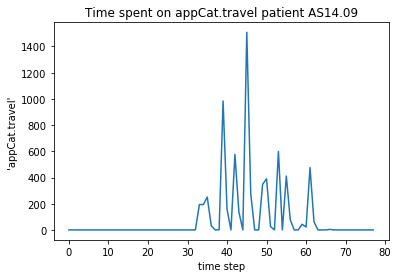

In [20]:
#any other statistics can be checked in here

patient_ids = ['AS14.01','AS14.02','AS14.03','AS14.05','AS14.06','AS14.07','AS14.08','AS14.09','AS14.12',
               'AS14.13','AS14.14','AS14.15','AS14.16','AS14.17','AS14.19','AS14.20','AS14.23','AS14.24',
               'AS14.25','AS14.26','AS14.27','AS14.28','AS14.29','AS14.30','AS14.31','AS14.32','AS14.33']

# example patient AS14.09
df_table = create_table_for_patient(df, 'AS14.09')
num_days = df_table.shape[0]

mood_list = np.array(df_table['mood'])
circ_arousal_list = np.array(df_table['circumplex.arousal'])
circ_valence_list = np.array(df_table['circumplex.valence'])

activity_list = np.array(df_table['activity'])
screen_list = np.array(df_table['screen'])

call_list = np.array(df_table['call'])
sms_list = np.array(df_table['sms'])

app_builtin_list = np.array(df_table['appCat.builtin'])
app_communication_list = np.array(df_table['appCat.communication'])
app_entertainment_list = np.array(df_table['appCat.entertainment'])
app_finance_list = np.array(df_table['appCat.finance'])
app_game_list = np.array(df_table['appCat.game'])
app_office_list = np.array(df_table['appCat.office'])
app_other_list = np.array(df_table['appCat.other'])
app_social_list = np.array(df_table['appCat.social'])
app_travel_list = np.array(df_table['appCat.travel'])
app_unknown_list = np.array(df_table['appCat.unknown'])
app_utilities_list = np.array(df_table['appCat.utilities'])
app_weather_list = np.array(df_table['appCat.weather'])


x = np.arange(0,num_days)

# Example:
plt.plot(x,app_travel_list)
plt.title("Time spent on appCat.travel patient AS14.09")
plt.ylabel("'appCat.travel'")
plt.xlabel("time step")
plt.show()

In [21]:
# Calculation of 4 variables which later are used to to pairwise comparison with temporal model
df_pat_01 = create_table_for_patient(df, 'AS14.01')
df_pat_23 = create_table_for_patient(df, 'AS14.23')

f_list_pat_01,t_list_pat_01,time_pat_01 = extract_data(df_pat_01)
DT_pred_pat_01 = DT_regressor.predict(f_list_pat_01)
f_list_pat_23,t_list_pat_23,time_pat_23 = extract_data(df_pat_23)
DT_pred_pat_23 = DT_regressor.predict(f_list_pat_23)

mood_list_pat_01 = np.array(df_pat_01['mood'])
mood_list_pat_23 = np.array(df_pat_23['mood'])

mood_pat_01_last_10 = mood_list_pat_01[67:77]
mood_pat_23_last_10 = mood_list_pat_23[63:73]

DT_pred_pat_01_last_10 = DT_pred_pat_01[32:42]
DT_pred_pat_23_last_10 = DT_pred_pat_23[23:33]

err_DT_pat_01_last_10 = np.zeros(10)
err_DT_pat_23_last_10 = np.zeros(10)
for k in range(0,10):
    err_DT_pat_01_last_10[k] = (mood_pat_01_last_10[k]-DT_pred_pat_01_last_10[k])**2
    err_DT_pat_23_last_10[k] = (mood_pat_23_last_10[k]-DT_pred_pat_23_last_10[k])**2

    
# These 2 variables now contain the squared errors of prediction for last 10 timesteps on patient 1 and 23    
#   err_DT_pat_01_last_10
#   err_DT_pat_23_last_10


# Temporal Model

In [34]:
#Data preprocessing
# Get the information of patient 1
# Write it to csv file
#p_1=df.loc[df['id']=='AS14.01']
#p_1.to_csv('patient_1.csv', sep=',')
p_1 = pd.read_csv('patient_1.csv', header=0, sep=',', index_col=0)
mood = pd.Series.from_csv('patient_1_mood.csv', header=0)

C:\Users\Veldema\Anaconda3\lib\site-packages\pandas\core\series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [35]:
#Data preprocessing SARIMAX 
# Granger causality test
def g_c(data):
    for k in data.columns:
        print('\n')
        print(k)
        print(grangercausalitytests(data[['mood', k]].dropna(),1))
        print(grangercausalitytests(data[[k, 'mood']].dropna(),1))
        print('\n')
g_c(p_1)



activity

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2214  , p=0.6405  , df_denom=41, df_num=1
ssr based chi2 test:   chi2=0.2376  , p=0.6260  , df=1
likelihood ratio test: chi2=0.2369  , p=0.6264  , df=1
parameter F test:         F=0.2214  , p=0.6405  , df_denom=41, df_num=1
{1: ({'ssr_ftest': (0.22137554269557547, 0.64048730037908952, 41.0, 1), 'ssr_chi2test': (0.23757375313671511, 0.62596399614142428, 1), 'lrtest': (0.23693467425965054, 0.62642887369830891, 1), 'params_ftest': (0.22137554269558743, 0.64048730037907919, 41.0, 1)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000020A6AF55F28>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000020A6ADB94A8>, array([[ 0.,  1.,  0.]])])}

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0017  , p=0.0308  , df_denom=41, df_num=1
ssr based chi2 test:   chi2=5.3677  , p=0.0205  , df=1
likelihood ratio test: chi2=5.0647  , p

ValueError: Insufficient observations. Maximum allowable lag is -1

In [36]:
#Model construction ARIMA for  Patient 01
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7,center=False).mean()
    rolstd = timeseries.rolling(window=7,center=False).std()
    plt.figure()
    #Plot rolling statistics:
    plt.figure()
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Decompose the trend
    plt.figure()
    decompose=seasonal_decompose(timeseries)
    dec=decompose.plot()
    dec.set_size_inches(25,16)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

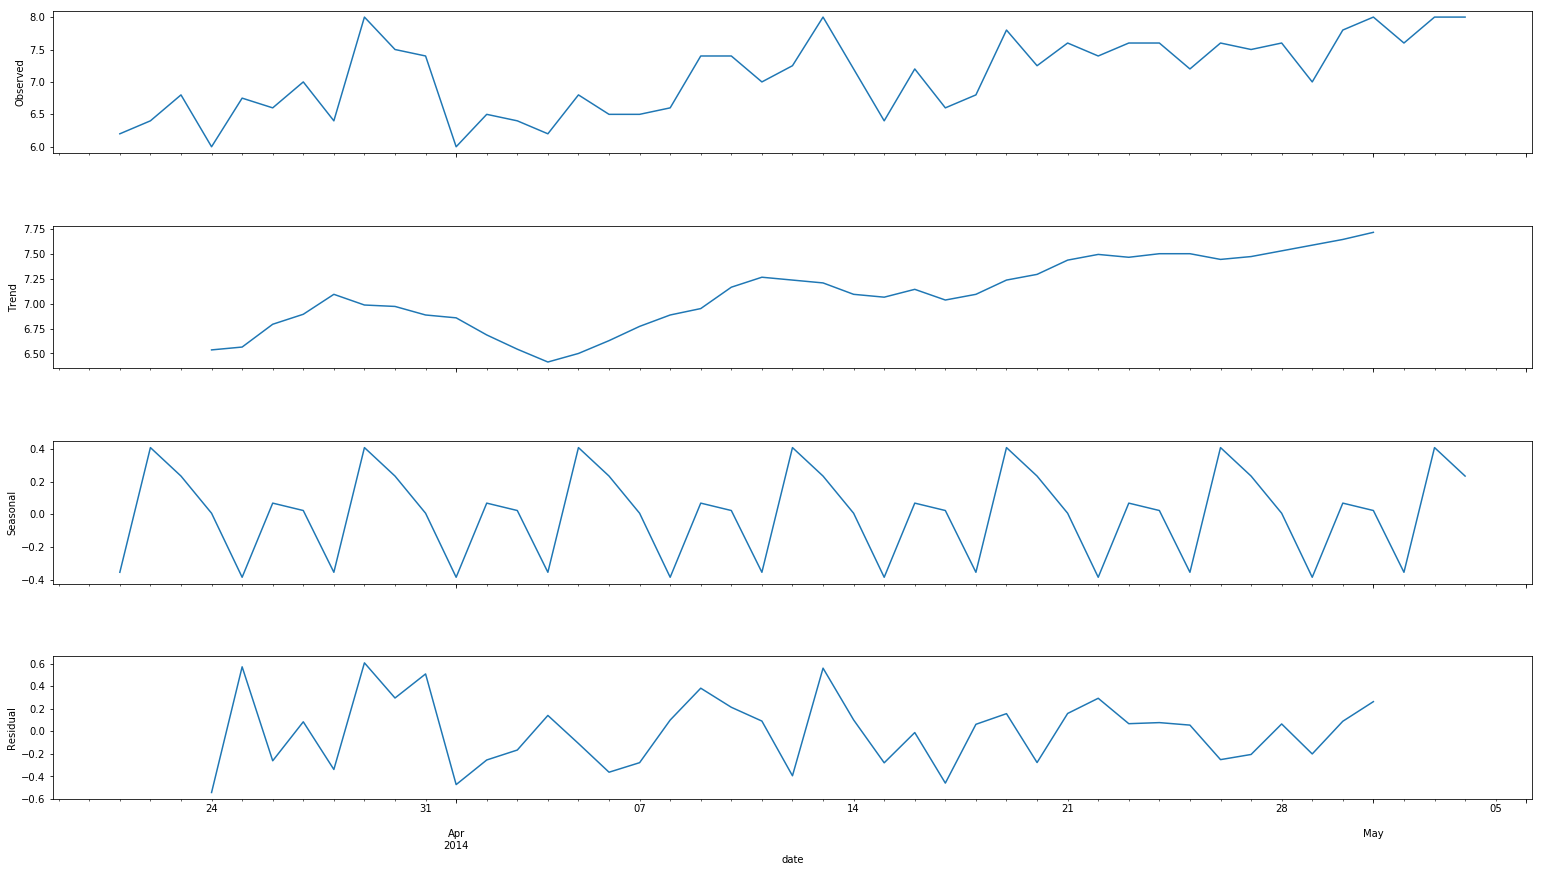

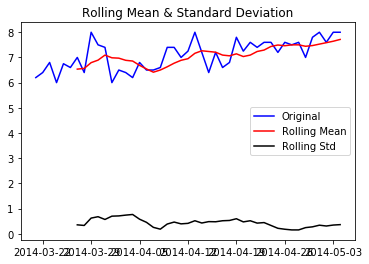

Results of Dickey-Fuller Test:
Test Statistic                 -3.679622
p-value                         0.004409
#Lags Used                      0.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64


In [38]:
test_stationarity(mood)

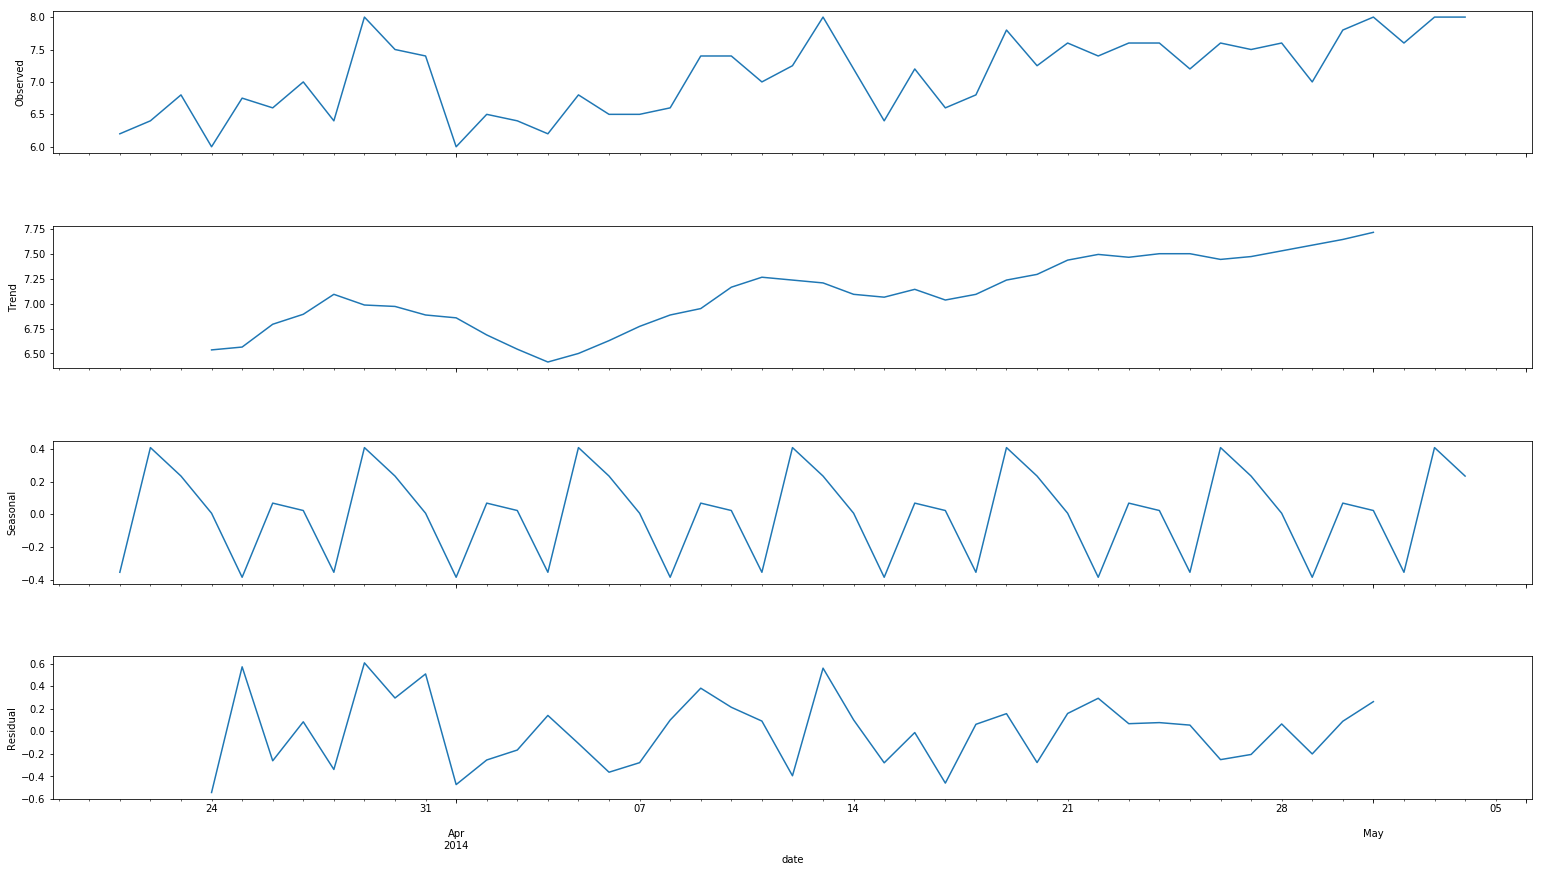

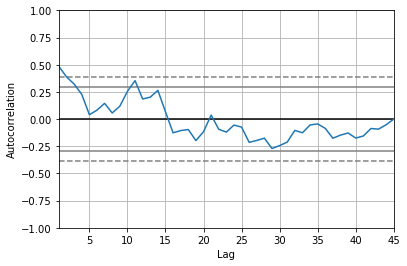

In [39]:
#utocorrelation plot
plt.figure()
fig_auto=autocorrelation_plot(mood.values)
plt.show(fig_auto)

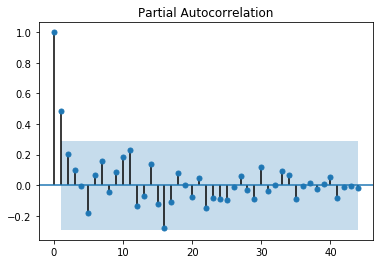

In [40]:
#Partial autocorrelation plot
plt.figure()
fig=plot_pacf(mood)
plt.show()

In [41]:
# Training and predicting

def arima_t_p(timeseries, p, d, q):
    X = timeseries.values
    train, test = X[:-10], X[-10:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit(disp=0)        
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat[0])
        obs = test[t]
        e_1=obs-yhat
        e_2=obs-test[t-1]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions)
    print('Test MSE: %.3f' % error)
    # plot
    E=plt.plot(test, label='expectation')
    P=plt.plot(predictions, color='red', label='prediction')
    bench=plt.plot(X[-11:-1], color='green', label='bench_mark')
    plt.title('Real Benchmark Prediction value comparison')
    plt.legend()
    plt.show()
    return predictions, error


predicted=7.495696, expected=7.200000
predicted=7.308087, expected=7.600000
predicted=7.467696, expected=7.500000
predicted=7.462095, expected=7.600000
predicted=7.498003, expected=7.000000
predicted=7.529140, expected=7.800000
predicted=7.522671, expected=8.000000
predicted=7.735646, expected=7.600000
predicted=7.627106, expected=8.000000
predicted=7.946092, expected=8.000000
Test MSE: 0.090


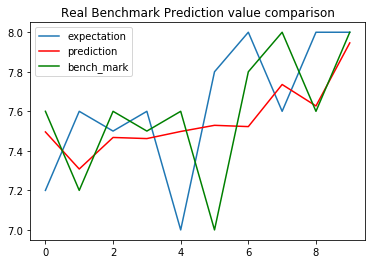

In [42]:
pre,error=arima_t_p(mood, 5, 1, 1)

In [43]:
#Runing the optimal ARIMA models
#def arima_model(timeseries, p,d,)
model=ARIMA(endog=mood,order=(5,1,1))
results=model.fit()
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   44
Model:                 ARIMA(5, 1, 1)   Log Likelihood                 -25.587
Method:                       css-mle   S.D. of innovations              0.412
Date:                Sun, 22 Apr 2018   AIC                             67.174
Time:                        10:02:14   BIC                             81.448
Sample:                    03-22-2014   HQIC                            72.468
                         - 05-04-2014                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0290      0.005      6.030      0.000       0.020       0.038
ar.L1.D.value     0.1596      0.142      1.126      0.268      -0.118       0.437
ar.L2.D.value     0.0569      0.142     

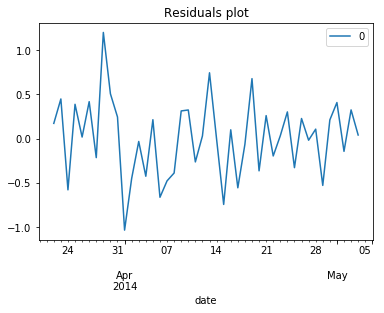

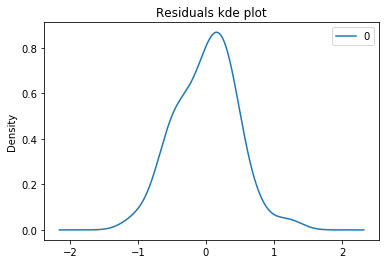

               0
count  44.000000
mean    0.004041
std     0.439096
min    -1.035144
25%    -0.338365
50%     0.029820
75%     0.303297
max     1.198530


In [44]:
# plot residual errors
residuals = pd.DataFrame(results.resid)
plt.figure()
A=residuals.plot()
plt.title("Residuals plot")
B=residuals.plot(kind='kde')
plt.title("Residuals kde plot")
plt.show()
print(residuals.describe())

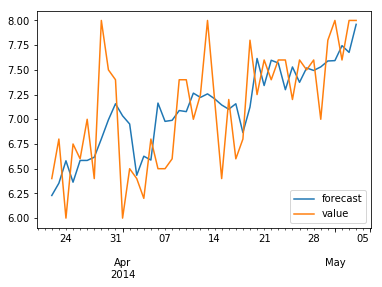

In [45]:
plt.title('Real vs. Forecast ARIMA')
results.plot_predict()

In [46]:
#SARIMAX model construction for patient 01
mood_other=p_1[['activity','appCat.entertainment', 'appCat.finance','circumplex.arousal','circumplex.valence','mood']]
#interpolate the missing values
for j in mood_other.columns:
     mood_other[j]=mood_other[j].interpolate()
mood_other=mood_other.dropna()

C:\Users\Veldema\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Veldema\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Veldema\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

In [47]:
endog=mood_other['mood']
exog=mood_other[['appCat.entertainment', 'circumplex.arousal','circumplex.valence' ]]

In [48]:
mod=SARIMAX(endog=mood_other['mood'],exog=exog, order=(7,1,2))
res = mod.fit(disp=False)
prediction=res.get_prediction()
print(res.summary())
mse=mean_squared_error(endog[36:], prediction.predicted_mean[36:])
print(mse)

                           Statespace Model Results                           
Dep. Variable:                   mood   No. Observations:                   46
Model:               SARIMAX(7, 1, 2)   Log Likelihood                 -16.753
Date:                Sun, 22 Apr 2018   AIC                             59.507
Time:                        10:03:14   BIC                             83.279
Sample:                    03-21-2014   HQIC                            68.412
                         - 05-05-2014                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
appCat.entertainment  3.739e-05   6.68e-05      0.560      0.576   -9.35e-05       0.000
circumplex.arousal      -0.0260      0.140     -0.185      0.853      -0.300       0.248
circumplex.v

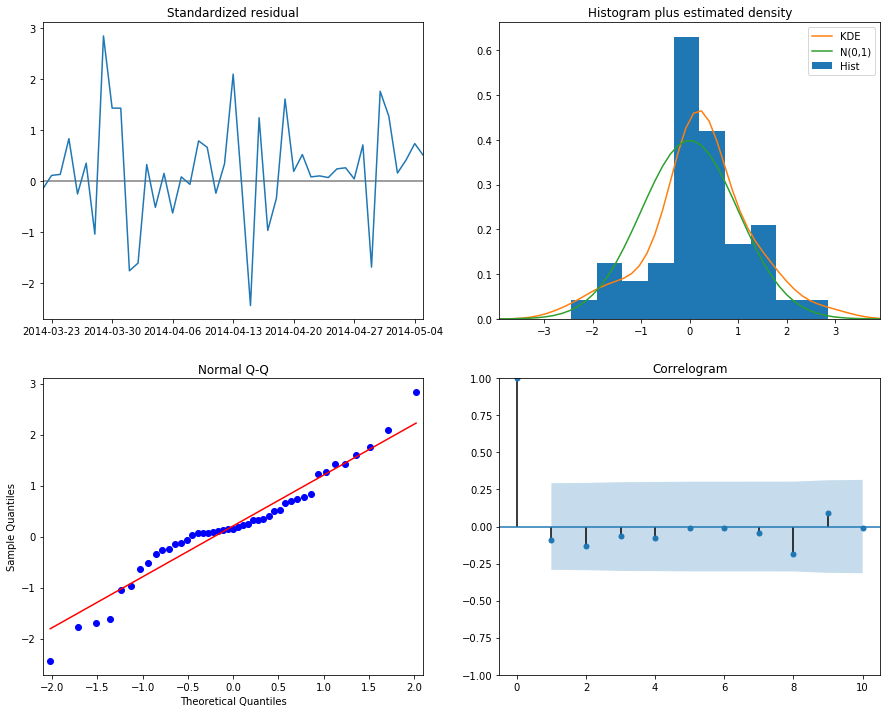

In [49]:
res.plot_diagnostics(figsize=(15, 12))

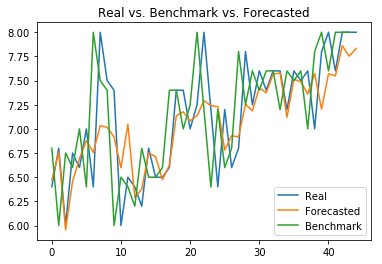

In [51]:
plt.figure()
A=plt.plot(endog.values[1:], label='Real')
B=plt.plot(prediction.predicted_mean.values[1:], label='Forecasted')
C=plt.plot(endog.values[2:], label='Benchmark')
plt.legend()
plt.title("Real vs. Benchmark vs. Forecasted")
plt.show()

In [54]:
%%capture
# Write it to csv file
#p_2=df.loc[df['id']=='AS14.23']
# check the time_series and drop unnecessary datapoints
#p_2 = p_2.groupby(['date','variable']).mean().squeeze().unstack().add_suffix('')
#p_2.to_csv('patient_2.csv', sep=',')
p_2 = pd.read_csv('patient_2.csv', header=0, sep=',', index_col=0)
mood_2= pd.Series.from_csv('patient_2_mood.csv')
mood_2=mood_2.interpolate()
test_stationarity(mood_2)

In [55]:
%%capture
fig_auto=autocorrelation_plot(mood_2.values)
plt.show(fig_auto)
ax2 = fig.add_subplot(212)
fig=plot_pacf(mood_2)
plt.show()

In [56]:
%%capture
pred, mse=arima_t_p(mood_2, 5, 1, 0)

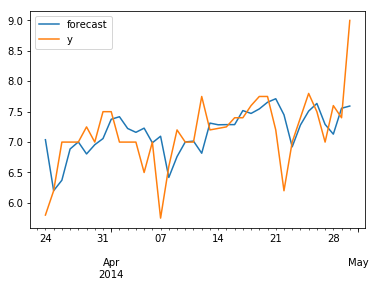

In [57]:
%%capture
model=ARIMA(endog=mood_2,order=(5,1,0))
results=model.fit()
print(results.summary())
results.plot_predict()

In [58]:
%%capture
other=p_2[['activity','appCat.entertainment','circumplex.arousal','circumplex.valence','mood']]
#interpolate the missing values
for j in other.columns:
     other[j]=other[j].interpolate()
other=other.dropna()

In [59]:
%%capture
endog_1=other['mood']
exog_1=other[['circumplex.arousal','circumplex.valence' ]]

In [60]:
%%capture
m=SARIMAX(endog=endog_1,exog=exog_1, order=(7,1,2))
r = m.fit(disp=False)
prediction_1=r.get_prediction()
print(r.summary())
mse=mean_squared_error(endog_1[-10:], prediction_1.predicted_mean[-10:])
print(mse)

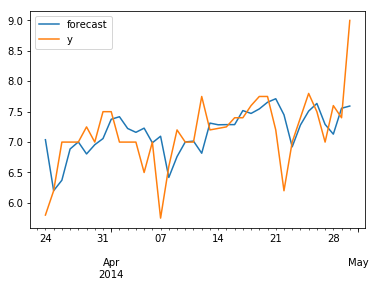

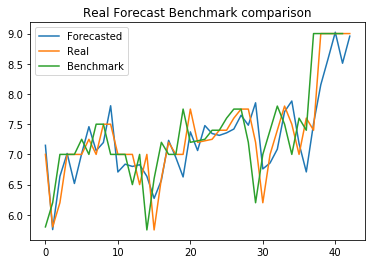

In [61]:
plt.figure()
B=plt.plot(prediction_1.predicted_mean.values[1:], label='Forecasted')
A=plt.plot(endog_1.values[1:], label='Real')
A=plt.plot(endog_1.values[2:], label='Benchmark')
plt.title('Real Forecast Benchmark comparison')
plt.legend()
plt.show()

In [62]:
#Model comparison (benchmark decision tree ARIMA SARIMAX model) patient 01
a=np.abs((mood.values[-10:]-pre)*2)
b=np.abs((mood.values[-10:]-mood.values[-11:-1:])**2)
c=(endog.values[-10:]-prediction.predicted_mean.values[-10:])**2
print("Benchmark vs. Decision Tree")
print(stats.ttest_ind(b, err_DT_pat_01_last_10))
print("Benchmark vs. ARIMA")
print(stats.ttest_ind(b, a))
print("Benchmark vs. SARIMA")
print(stats.ttest_ind(b, c))
print("ARIMA vs. Decision Tree")
print(stats.ttest_ind(a, err_DT_pat_01_last_10))
print("SARIMAX vs. Decision Tree")
print(stats.ttest_ind(c, err_DT_pat_01_last_10))
print("SARIMAX vs. ARIMA")
print(stats.ttest_ind(c, a))

Benchmark vs. Decision Tree
Ttest_indResult(statistic=-1.0059673750764644, pvalue=0.32776384326952923)
Benchmark vs. ARIMA
Ttest_indResult(statistic=-2.8251902034257723, pvalue=0.011214098394029089)
Benchmark vs. SARIMA
Ttest_indResult(statistic=0.8596220647361511, pvalue=0.4013015454934088)
ARIMA vs. Decision Tree
Ttest_indResult(statistic=2.06931059312467, pvalue=0.053185503802484171)
SARIMAX vs. Decision Tree
Ttest_indResult(statistic=-2.01408236473821, pvalue=0.059194489545016236)
SARIMAX vs. ARIMA
Ttest_indResult(statistic=-3.6288065797895745, pvalue=0.0019201035111686968)


In [63]:
#Model comparison (benchmark decision tree ARIMA SARIMAX model) patient 23
e=(pred-mood_2.values[-10:])**2
f=(mood_2.values[-11:-1]-mood_2.values[-10:])**2
g=(endog_1.values[-10:]-prediction_1.predicted_mean.values[-10:])**2
print("Benchmark vs. Decision Tree")
print(stats.ttest_ind(f, err_DT_pat_23_last_10))
print("Benchmark vs. ARIMA")
print(stats.ttest_ind(f, e))
print("Benchmark vs. SARIMA")
print(stats.ttest_ind(f, g))
print("ARIMA vs. Decision Tree")
print(stats.ttest_ind(e, err_DT_pat_23_last_10))
print("SARIMAX vs. Decision Tree")
print(stats.ttest_ind(g, err_DT_pat_23_last_10))
print("SARIMAX vs. ARIMA")
print(stats.ttest_ind(g, e))
#print(stats.wilcoxon(a,b))
#print(stats.ks_2samp(mood_2.values[-10:],pred))
#print(stats.ks_2samp(mood_2.values[-10:],mood_2.values[-11:-1]))

Benchmark vs. Decision Tree
Ttest_indResult(statistic=-0.027331646006179235, pvalue=0.97849596288051288)
Benchmark vs. ARIMA
Ttest_indResult(statistic=-0.09386851558320386, pvalue=0.92625059246961783)
Benchmark vs. SARIMA
Ttest_indResult(statistic=1.3282675239346826, pvalue=0.20068639558910586)
ARIMA vs. Decision Tree
Ttest_indResult(statistic=0.054306273640448842, pvalue=0.95728936591163849)
SARIMAX vs. Decision Tree
Ttest_indResult(statistic=-1.0545719301454541, pvalue=0.30557157509092125)
SARIMAX vs. ARIMA
Ttest_indResult(statistic=-1.3324339315156108, pvalue=0.19934136059816707)
